[*********************100%***********************]  1 of 1 completed
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            8100      
                                                                 
 gru_1 (GRU)                 (None, 60, 50)            15300     
                                                                 
 gru_2 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 38751 (151.37 KB)
Trainable params: 38751 (151.37 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 11s 274ms/step - loss: 0.102

10/10 [==============================] - 1s 91ms/step - loss: 7.4536e-04 - val_loss: 5.1010e-04
Epoch 69/100
10/10 [==============================] - 1s 91ms/step - loss: 6.4890e-04 - val_loss: 4.6902e-04
Epoch 70/100
10/10 [==============================] - 1s 91ms/step - loss: 6.7209e-04 - val_loss: 4.2552e-04
Epoch 71/100
10/10 [==============================] - 1s 91ms/step - loss: 6.5844e-04 - val_loss: 4.1697e-04
Epoch 72/100
10/10 [==============================] - 1s 92ms/step - loss: 6.6401e-04 - val_loss: 5.3475e-04
Epoch 73/100
10/10 [==============================] - 1s 92ms/step - loss: 6.5174e-04 - val_loss: 6.0144e-04
Epoch 74/100
10/10 [==============================] - 1s 92ms/step - loss: 7.0738e-04 - val_loss: 4.9174e-04
Epoch 75/100
10/10 [==============================] - 1s 91ms/step - loss: 6.5175e-04 - val_loss: 4.2982e-04
Epoch 76/100
10/10 [==============================] - 1s 91ms/step - loss: 6.6576e-04 - val_loss: 4.4673e-04
Epoch 77/100
10/10 [============

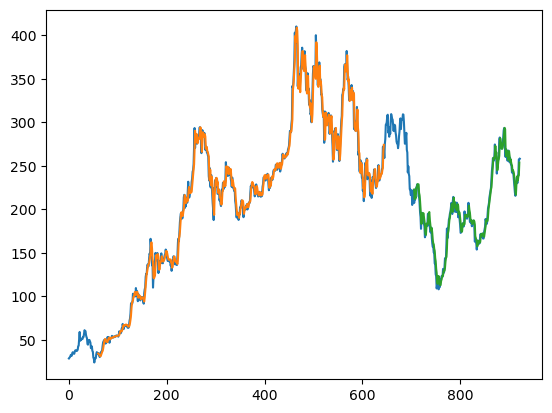

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU
import matplotlib.pyplot as plt
import time

# Download stock data
symbol = "TSLA"
data = yf.download(symbol, start="2020-01-01", end="2023-09-01")
price_volume_data = data[['Close', 'Volume']].values

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(price_volume_data)

# Split train and test set
train_size = int(len(scaled_data)*0.7) # 70% training, 30% testing
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# calling the create dataset function to split the data into 
# input output datasets with time step 60
time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)



# build GRU model
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))  # input layer
model.add(GRU(50, return_sequences=True))  # hidden layer
model.add(GRU(50))  # hidden layer
model.add(Dense(1))  # output layer
model.compile(loss='mean_squared_error', optimizer='adam')

# summarize model
model.summary()

# check the running time
start_time = time.time()

model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100, batch_size=64, verbose=1)

# end to check the time
end_time = time.time()

# print the running time
print("Learning time: ", end_time - start_time, "seconds")

# Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# transform to original form
train_predict = scaler.inverse_transform(np.column_stack((train_predict, np.zeros_like(train_predict))))
test_predict = scaler.inverse_transform(np.column_stack((test_predict, np.zeros_like(test_predict))))
train_predict = train_predict[:, 0]
test_predict = test_predict[:, 0]

Y_train_orig = scaler.inverse_transform(np.column_stack((Y_train, np.zeros_like(Y_train))))[:, 0]
Y_test_orig = scaler.inverse_transform(np.column_stack((Y_test, np.zeros_like(Y_test))))[:, 0]

# Calculate RMSE
print("Training RMSE:", np.sqrt(mean_squared_error(Y_train_orig, train_predict)))
print("Testing RMSE:", np.sqrt(mean_squared_error(Y_test_orig, test_predict)))

## Plotting
look_back = 60
trainPredictPlot = np.empty_like(price_volume_data[:, 0])
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back] = train_predict

testPredictPlot = np.empty_like(price_volume_data[:, 0])
testPredictPlot[:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2) + 1:len(scaled_data) - 1] = test_predict

plt.plot(scaler.inverse_transform(scaled_data)[:, 0])
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show() # Orange is the TrainPredictPlot, Green is TestPredictPlot